In [ ]:
#from google.colab import auth
#auth.authenticate_user()

In [ ]:
!nvidia-smi

Wed May 26 05:05:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir train
!unzip '/content/drive/MyDrive/bms-molecular-translation/train.zip' -d '/content/train'

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.optimizers as O
import tensorflow.keras.losses as Loss

from tqdm import tqdm

from PIL import Image
import cv2

import matplotlib.pyplot as plt

from datetime import date
import keras.backend as K

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16280)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_path = 'train/'

In [ ]:
labels = pd.read_csv("train/_labels.csv")

In [ ]:
labels

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...


In [ ]:
for i in tqdm(range(len(labels))):
    labels.InChI.values[i] = labels.InChI.values[i][9:]
    labels.InChI.values[i] = '#'+labels.InChI.values[i] + '$'
    image_id = labels.image_id.values[i]
    labels.image_id.values[i] = train_path+image_id[0]+'/'+image_id[1]+'/'+image_id[2]+'/'+image_id+'.png'
labels.head()

100%|██████████| 2424186/2424186 [01:42<00:00, 23644.72it/s]


,image_id,InChI
0,train/0/0/0/000011a64c74.png,#C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4...
1,train/0/0/0/000019cc0cd2.png,#C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-...
2,train/0/0/0/0000252b6d2b.png,#C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(...
3,train/0/0/0/000026b49b7e.png,#C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11...
4,train/0/0/0/000026fc6c36.png,#C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3...


In [ ]:
labels.InChI.values[:10]

array(['#C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3$',
       '#C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1$',
       '#C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)$',
       '#C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)$',
       '#C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)$',
       '#C19H22Br2N2O2/c1-13(2)10-16(19(24)25)23(9-8-14-6-4-3-5-7-14)15-11-17(20)22-18(21)12-15/h3-7,11-13,16H,8-10H2,1-2H3,(H,24,25)$',
       '#C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12(10-19)16-20-15-8-4-2-6-13(15)17(22)21-16/h1-9,13H/b12-9+$',
       '#C21H21N5O2S/c1-15-7-8-18(17-5-4-11-22-20(15)17)29(27,28)25-13-9-16(10-14-25)21-24-23-19-6-

In [ ]:
top_words = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_words,oov_token='<unk>',filters='!"%&*.:;=?@[\]^_`{|}~ ',char_level=False)

In [ ]:
tokenizer.fit_on_texts(labels.InChI.values)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
tokenized_text = tokenizer.texts_to_sequences(list(labels.InChI.values))
padded_tokenized_text = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text,padding='post')

In [ ]:
print(tokenized_text[0],labels.InChI.values[0])

[19, 18, 2, 5, 9, 4, 16, 22, 23, 17, 18, 2, 3, 15, 7, 4, 8, 14, 3, 2, 11, 3, 2, 5, 3, 12, 3, 11, 3, 2, 16, 7, 5, 8, 13, 3, 2, 4, 7, 2, 5, 8, 2, 2, 7, 10, 8, 2, 10, 17, 9, 11, 3, 13, 6, 15, 6, 2, 2, 6, 2, 10, 9, 6, 14, 9, 4, 6, 2, 3, 10, 9, 5, 20] #C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3$


In [ ]:
[19, 18, 2, 5, 9, 4, 16, 22, 23, 17, 18, 2, 3, 15, 7, 4, 8, 14, 3, 2, 11, 3, 2, 5, 3, 12, 3, 11, 3, 2, 16, 7, 5, 8, 13, 3, 2, 4, 7, 2, 5, 8, 2, 2, 7, 10, 8, 2, 10, 17, 9, 11, 3, 13, 6, 15, 6, 2, 2, 6, 2, 10, 9, 6, 14, 9, 4, 6, 2, 3, 10, 9, 5, 20]

In [ ]:
print(padded_tokenized_text[0])

[19 18  2  5  9  4 16 22 23 17 18  2  3 15  7  4  8 14  3  2 11  3  2  5
  3 12  3 11  3  2 16  7  5  8 13  3  2  4  7  2  5  8  2  2  7 10  8  2
 10 17  9 11  3 13  6 15  6  2  2  6  2 10  9  6 14  9  4  6  2  3 10  9
  5 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_len = calc_max_length(tokenized_text)
print(max_len)

396


In [ ]:
labels = labels[:100000]

In [ ]:
today = date.today()
BATCH_SIZE = 64
EPOCHS = 20
rnn_units = 512
DIM =(100,100)
attention_feature_shape = 81
features_dim = 512
embedding_dim = 256
vocab_size = len(tokenizer.word_index)
num_steps = len(labels)//BATCH_SIZE

In [ ]:
img = cv2.imread(labels.image_id.values[0],cv2.IMREAD_GRAYSCALE)

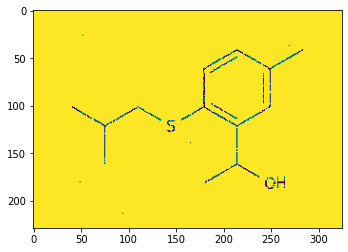

In [ ]:
plt.imshow(img)
#plt.title(labels.InChI.values[0])

In [ ]:
split_percentage = 1

split = len(labels) - int(len(labels)/100)*(split_percentage)
print(split)

99000


In [ ]:
train_data = labels[:split]
print(len(train_data))
padded_tokenized_text = padded_tokenized_text[:split]
print(len(padded_tokenized_text))

99000
99000


In [ ]:
def preprocess_image(image_id,label):
    image = tf.io.read_file(image_id)                            
    image = tf.image.decode_png(image,channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,size=[DIM[0],DIM[1]])
    return image,label

train_dataset = tf.data.Dataset.from_tensor_slices((train_data.image_id.values,padded_tokenized_text))
#val_dataset = tf.data.Dataset.from_tensor_slices((val_data.image_id.values,padded_tokenized_text[split:]))
train_dataset = train_dataset.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [ ]:
class Attention(tf.keras.Model):
    def __init__(self,rnn_units):
        super(Attention,self).__init__()
        self.W1 = L.Dense(rnn_units)
        self.W2 = L.Dense(rnn_units)
        self.V = L.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden,1)
        attention_layer = (tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))
        attention_score = self.V(attention_layer)

        attention_weights = tf.nn.softmax(attention_score,axis=1)
        context_vector = attention_weights*features
        context_vector = tf.reduce_sum(context_vector,axis=1)

        return context_vector,attention_weights

class CNN_encoder(tf.keras.Model):
    def __init__(self,input_dim,feature_dim,attention_feature_shape):
        super(CNN_encoder,self).__init__()
        # self.inp = L.Input(shape=(input_dim[0],input_dim[1],1))
        self.batch_norm1 = L.BatchNormalization()
        self.batch_norm2 = L.BatchNormalization()
        self.batch_norm3 = L.BatchNormalization()
        self.batch_norm4 = L.BatchNormalization()
        self.batch_norm5 = L.BatchNormalization()
        self.batch_norm6 = L.BatchNormalization()
        self.actvt1 = L.Activation('relu')
        self.actvt2 = L.Activation('relu')
        self.actvt3 = L.Activation('relu')
        self.actvt4 = L.Activation('relu')
        self.actvt5 = L.Activation('relu')
        self.actvt6 = L.Activation('relu')
        self.actvt7 = L.Activation('relu')
        self.max1 = L.MaxPooling2D()
        self.max2 = L.MaxPooling2D()
        self.max3 = L.MaxPooling2D()
        self.dropout1 = L.Dropout(0.3)
        self.dropout2 = L.Dropout(0.3)
        self.dropout3 = L.Dropout(0.3)
        self.conv2d1 = L.Conv2D(16,3)
        self.conv2d2 = L.Conv2D(32,3)
        self.conv2d3 = L.Conv2D(64,3)
        self.conv2d4 = L.Conv2D(128,3)
        self.conv2d5 = L.Conv2D(256,3)
        self.conv2d6 = L.Conv2D(512,3)
        self.reshape = L.Reshape(target_shape=[attention_feature_shape,feature_dim])
        self.fc = L.Dense(embedding_dim)
    
    def call(self,input_image):
         x = self.conv2d1(input_image)
         x = self.batch_norm1(x)         
         x = self.actvt1(x)
         x = self.conv2d2(x)
         x = self.batch_norm2(x)         
         x = self.actvt2(x)
         x = self.max1(x)
         x = self.dropout1(x)
         x = self.conv2d3(x)
         x = self.batch_norm3(x)         
         x = self.actvt3(x)
         x = self.conv2d4(x)
         x = self.batch_norm4(x)         
         x = self.actvt4(x)
         x = self.max2(x)
         x = self.dropout2(x)
         x = self.conv2d5(x)
         x = self.batch_norm5(x)         
         x = self.actvt5(x)
         x = self.conv2d6(x)
         x = self.batch_norm6(x)         
         x = self.actvt6(x)
         x = self.max3(x)
         x = self.dropout3(x)
         x = self.reshape(x)
         x = self.fc(x)
         x = self.actvt7(x)
         return x

class RNN_decoder(tf.keras.Model):
    def __init__(self,rnn_units,vocab_size,embedding_dim):
        super(RNN_decoder,self).__init__()
        self.units = rnn_units
        self.attention = Attention(self.units)
        self.embedding = L.Embedding(input_dim = vocab_size,output_dim = embedding_dim)
        self.gru = L.GRU(self.units,return_sequences=True, return_state=True,recurrent_initializer='glorot_uniform')
        self.fc1 = L.Dense(self.units)
        self.fc2 = L.Dense(vocab_size)
        self.reshape = L.Reshape((-1,self.units))
    def call(self,x,features,hidden):
        context_vector,attention_weights = self.attention(features,hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        output,hidden = self.gru(x)
        x = self.fc1(output)
        x = self.reshape(x)
        x = self.fc2(x)
        return x, hidden,attention_weights

    def reset_state(self,batch_size):
        return tf.zeros((batch_size,self.units))

In [ ]:
encoder = CNN_encoder(DIM,features_dim,attention_feature_shape)
decoder = RNN_decoder(rnn_units,vocab_size,embedding_dim)

In [ ]:
optimizer = O.Adam(learning_rate=1e-3)
loss_object = Loss.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real,pred)
    mask = tf.cast(mask,dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/bms-molecular-translation/checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
@tf.function
def train_step(image_tensor,label):
    loss = 0
    hidden = decoder.reset_state(batch_size=label.shape[0])
    decoder_input = tf.expand_dims([tokenizer.word_index['#']]*label.shape[0],1)
    with tf.GradientTape() as tape:
        features = encoder(image_tensor)
        for i in range(1,label.shape[1]):
            predictions, hidden ,_ = decoder(decoder_input,features,hidden)

            loss += loss_function(label[:,i],predictions)
            decoder_input = tf.expand_dims(label[:,i],1)

    total_loss = (loss/int(label.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [ ]:
padded_tokenized_text[0].shape

(396,)

In [ ]:
import time
loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
 
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
 
        if batch % 500 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
 
    ckpt_manager.save()
 
    loss_plot.append(total_loss / num_steps)
 
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 1 Batch 0 Loss 1.0949
Epoch 1 Batch 500 Loss 0.5034
Epoch 1 Batch 1000 Loss 0.5179
Epoch 1 Batch 1500 Loss 0.5053
Epoch 1 Loss 0.503291
Time taken for 1 epoch 2898.59 sec

Epoch 2 Batch 0 Loss 0.5019
Epoch 2 Batch 500 Loss 0.5097
Epoch 2 Batch 1000 Loss 0.4825
Epoch 2 Batch 1500 Loss 0.5039
Epoch 2 Loss 0.495919
Time taken for 1 epoch 1827.67 sec

Epoch 3 Batch 0 Loss 0.4906
Epoch 3 Batch 500 Loss 0.4539
Epoch 3 Batch 1000 Loss 0.5439
Epoch 3 Batch 1500 Loss 0.4813
Epoch 3 Loss 0.495872
Time taken for 1 epoch 1829.86 sec

Epoch 4 Batch 0 Loss 0.5007
Epoch 4 Batch 500 Loss 0.5323
Epoch 4 Batch 1000 Loss 0.4871
Epoch 4 Batch 1500 Loss 0.5095
Epoch 4 Loss 0.495803
Time taken for 1 epoch 1810.10 sec

Epoch 5 Batch 0 Loss 0.5405
Epoch 5 Batch 500 Loss 0.4998


In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [ ]:
def preprocess_test_image(image_id):
    image = tf.io.read_file(image_id)                            
    image = tf.image.decode_png(image,channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,size=[DIM[0],DIM[1]])
    return image

def test_func(image_id):
    attention_plot = np.zeros((max_len,attention_feature_shape))
    image = preprocess_test_image(image_id)
    image = tf.expand_dims(image,0)
    features = encoder(image)
    dec_input = tf.expand_dims([tokenizer.word_index['#']],0)
    hidden = decoder.reset_state(batch_size=1)
    result = []
    for i in range(max_len):
        predictions, hidden,attention_weights = decoder(dec_input,features,hidden)
        attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()
        predicted_id = tf.random.categorical([predictions[0][0]],1).numpy()
        result.append(tokenizer.index_word[int(predicted_id[0][0])])
        if tokenizer.index_word[int(predicted_id[0][0])] == '$':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id[0][0]],0)
    attention_plot = attention_plot[:len(result),:]
    return result, attention_plot


In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [ ]:
def edit_dist_loss(y_true,y_pred):
    y_true = tf.sparse.from_dense(y_true)
    y_pred = tf.sparse.from_dense(y_pred)
    loss = tf.edit_distance(y_true, y_pred,normalize=True)
    return tf.reduce_mean(loss)

In [ ]:
image_id = 99999
image = labels.image_id.values[image_id]
label = labels.InChI.values[image_id]

result,attention_plot = test_func(image)

print('Real InChI notation: ', label)
print('Predicted InChI notation: ', ''.join(result))

plot_attention(image,result,attention_plot)

label_for_edit_dist = np.array([x for x in label])
label_for_edit_dist = np.reshape(label_for_edit_dist,(label_for_edit_dist.shape[0],1))
result_for_edit_dist = np.reshape(result,(len(result),1))
print('Levenshtein Loss: ',edit_dist_loss(label_for_edit_dist,result_for_edit_dist))

In [ ]:
def edit_dist_loss2(y_true,y_pred):
    y_true = tf.math.argmax(y_true,axis=-1,output_type=tf.int32)
    y_pred = tf.math.argmax(y_pred,axis=-1,output_type=tf.int32)
    loss = tf.math.subtract(y_true,y_pred)
    low = tf.less(0,loss)
    high = tf.less(loss,0)
    low = tf.cast(low,dtype=tf.int32)
    high = tf.cast(high,dtype=tf.int32)
    loss = tf.math.add(low,high)
    loss = tf.cast(tf.reduce_sum(loss,axis=-1),dtype=tf.float32)
    #loss = tf.cast(tf.reduce_mean(loss,keepdims=True),dtype=tf.float32)
    return loss

In [ ]:
def cnn_encoder(dim):
    initializer = tf.keras.initializers.GlorotUniform()
    encoder_inp = L.Input(shape=(dim[0],dim[1],1),name='encoder_input')
    X = L.BatchNormalization(name='norm1')(encoder_inp)
    X = L.Conv2D(16,3,name='Conv2d1')(X)
    X = L.Activation('relu',name='relu1')(X)
    X = L.Conv2D(32,3, name='Conv2d2')(X)
    X = L.BatchNormalization(name='norm2')(X)
    X = L.Activation('relu',name='relu2')(X)
    X = L.MaxPooling2D(name='max1')(X)
    X = L.Dropout(0.3)(X)
    X = L.Conv2D(64,3,name='Conv2d3')(X)
    X = L.BatchNormalization(name='norm3')(X)
    X = L.Activation('relu',name='relu3')(X)
    X = L.Conv2D(128,3,name='Conv2d4')(X)
    X = L.BatchNormalization(name='norm4')(X)
    X = L.Activation('relu',name='relu4')(X)
    X = L.MaxPooling2D(name='max2')(X)
    X = L.Dropout(0.3)(X)
    X = L.Conv2D(256,3,name='Conv2d5')(X)
    X = L.BatchNormalization(name='norm5')(X)
    X = L.Activation('relu',name='relu5')(X)
    X = L.Conv2D(512,3,name='Conv2d6')(X)
    X = L.BatchNormalization(name='norm6')(X)
    X = L.Activation('relu',name='relu6')(X)
    X = L.MaxPooling2D(name='max3')(X)
    X = L.Dropout(0.3)(X)
    embedding = L.Reshape((-1,X.shape[3]),name='embed1')(X)
    model = M.Model(inputs = encoder_inp,outputs=embedding)
    model.compile(loss = 'mse',optimizer='adam')
    return model

model = build_second_model_1_0(DIM)
model.summary()

In [ ]:
K.clear_session()

In [ ]:
!unzip '/content/drive/MyDrive/bms-molecular-translation/sample_submission.csv.zip'

In [ ]:
sampl = pd.read_csv('sample_submission.csv')

In [ ]:
test_path = 'test'
for i in tqdm(range(len(sampl))):
    image_id = sampl.image_id.values[i]
    sampl.image_id.values[i] = test_path+'/'+image_id[0]+'/'+image_id[1]+'/'+image_id[2]+'/'+image_id+'.png'
sampl.head()

In [ ]:
sampl

,image_id,InChI
0,test/0/0/0/00000d2a601c.png,InChI=1S/H2O/h1H2
1,test/0/0/0/00001f7fc849.png,InChI=1S/H2O/h1H2
2,test/0/0/0/000037687605.png,InChI=1S/H2O/h1H2
3,test/0/0/0/00004b6d55b6.png,InChI=1S/H2O/h1H2
4,test/0/0/0/00004df0fe53.png,InChI=1S/H2O/h1H2
...,...,...
1616102,test/f/f/f/ffffcdb2e39e.png,InChI=1S/H2O/h1H2
1616103,test/f/f/f/ffffcfddd770.png,InChI=1S/H2O/h1H2
1616104,test/f/f/f/ffffe4ab06b2.png,InChI=1S/H2O/h1H2
1616105,test/f/f/f/ffffec4033ec.png,InChI=1S/H2O/h1H2


In [ ]:
#model = M.load_model('/content/drive/MyDrive/bms-molecular-translation/Models/phase1-base-model-47-0.7992.hdf5')

In [ ]:
def detokenize(pred):
    string_d = []
    for i in range(len(pred)):
        a = []
        for j in range(len(pred[i])):
            if pred[i][j] in detokens3.keys():
                a.append(detokens3[pred[i][j]])
            else:
                a.append(str(pred[i][j]-47))
        a = "".join(a)
        string_d.append(a)
    return string_d

for i in range(2):
    test_data = tf.data.Dataset.from_tensor_slices(labels.image_id.values[:10]).map(preprocess_test_image,num_parallel_calls=tf.data.AUTOTUNE).batch(10,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    pred = model.predict(test_data,verbose=1)
    #pred = tf.random.uniform(shape=[len(sampl)//100,MAX_LENGTH,vocab])
    pred = tf.argmax(pred,axis=-1)
    pred = np.array(pred)
    pred = detokenize(pred)
    pred = np.char.strip(pred,chars='$')
    labels.InChI.values[:10] = pred
    

1/1 [==============================] - 12s 12s/step


In [ ]:
pred

array(['111111111111,,,,,,,,', '111111111111,,,,,,,,,,',
       '1111111111111,,,,,,,,', '1111111111111,,,,,,',
       '1111111111111,,,,,,,,,,,', '11111111111,,,,,,,,',
       '1111111111111,,,,,,,', '1111111111111,,,,,,,,,,',
       '1111111111111,,,,,,,,,', '111111111111,,,,,,,,,'], dtype='<U192')

In [ ]:
labels

,image_id,InChI
0,train/0/0/0/000011a64c74.png,"111111111111,,,,,,,,"
1,train/0/0/0/000019cc0cd2.png,"111111111111,,,,,,,,,,"
2,train/0/0/0/0000252b6d2b.png,"1111111111111,,,,,,,,"
3,train/0/0/0/000026b49b7e.png,"1111111111111,,,,,,"
4,train/0/0/0/000026fc6c36.png,"1111111111111,,,,,,,,,,,"
...,...,...
2424181,train/f/f/f/ffffe824f539.png,"h2,10H,3-4,13H2,1H3,(H,15,16)$$$$$$$$$$$$$$$$$..."
2424182,train/f/f/f/ffffea1ebdfa.png,"h3-4,7,9-10,26H,5-6,8H2,1-2H3,(H,22,27)(H,23,2..."
2424183,train/f/f/f/ffffee2b4534.png,"h2-4,6,8-10,17H,5,7,11-15H2,1H3,(H,25,27)$$$$$..."
2424184,train/f/f/f/fffff0b6eea6.png,"h4-5,12-13H,3,6-11,18H2,1-2H3$$$$$$$$$$$$$$$$$..."


Text(0.5, 1.0, '')

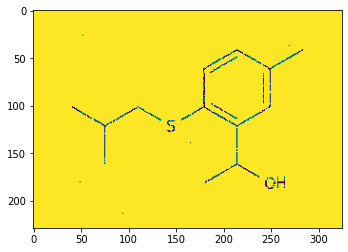

In [ ]:
img = cv2.imread(labels.image_id.values[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.title(labels.InChI.values[0])

In [ ]:
#test_data = tf.data.Dataset.from_tensor_slices(sampl.image_id.values[:len(sampl)//2]).map(preprocess_test_image,num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
#pred = model.predict(test_data,verbose=1)

In [ ]:
#pred

def detokenize(pred):
    string_d = []
    for i in range(len(pred)):
        a = []
        for j in range(len(pred[i])):
            if pred[i][j] in detokens.keys():
                a.append(detokens[pred[i][j]])
            else:
                a.append(str(pred[i][j]-47))
        a = "".join(a)
        string_d.append(a)
    return string_d

In [ ]:
#pred = tf.argmax(pred,axis=-1)
#pred = np.array(pred)

In [ ]:
#pred = detokenize(pred)

In [ ]:
#pred = np.char.strip(pred,chars='$')

In [ ]:
#sampl.InChI.values = pred

In [ ]:
#test_data = tf.data.Dataset.from_tensor_slices(sampl.image_id.values[len(sampl)//2:]).map(preprocess_test_image,num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
#pred = model.predict(test_data,verbose=1)

In [ ]:
sampl.to_csv('submission.csv',index=False)